# Hipótesis

Tenemos:

1) Hay privilegio para los grupos de conectar con SC
2) Éste privilegio está sesgado en favor de los hombres

Tenemos tres hipótesis
 1) Las mujeres se salen de la carrera
 
 2) Hay una diferencia de conexión local a SC entre hombres y mujeres
 
 3) Hay otro sesgo de género presente que no tiene que ver con estructurada de redes

# Hipotesis 2

Hay una diferencia en la conectividad local entre los que están conectados con SC:

1. Los exitosos 5 años después tienen más conexiones
2. Los exitosos 5 años después tienen más colaboraciones

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.impute import SimpleImputer

### Citation table

We take cites from 1990 to 2019 avoiding self-cites.

In [4]:
cite = pd.read_csv("../data/processed/cites.csv")

cite = cite[(cite.t_year >= 1990) & (cite.t_year < 2020)]
cite = cite[(cite.s_year >= 1990) & (cite.s_year < 2020)]

cite = cite[cite.target != cite.source]

In [5]:
papers = pd.read_csv("../data/processed/adjacency_papers.csv")

papers = papers[(papers.t_year >= 1990) & (papers.t_year < 2020)]
papers = papers[(papers.s_year >= 1990) & (papers.s_year < 2020)]

papers = papers[papers.target != papers.source]

### Authors table

There are two author tables: 

1. One with the comparable groups A and B (`people`) and 
2. the one with the all the authors found in the RePEc repository (`all_people`).

In [90]:
people = pd.read_csv("../data/processed/network_people.csv")
all_people = pd.read_csv("../data/processed/people.csv")

### Places table

We use the institution to infer the place of work of the authors. We have:

1. The region (continent)
2. The sub-region (sub-continent)
3. Country 3-letter code
4. The institution's name

In [7]:
places = pd.read_csv("../data/processed/institution.csv")

places = places[['Handle', 'Primary-Name', 'alpha-3', 'region', 'sub-region']].set_index("Handle")

### Adding place of work to people

In [91]:
all_people = pd.merge(all_people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

# all_people = all_people[all_people.region.notna()]

### Adding gender to the citation table

We have two genders for each cite:

1. Gender of the source (`gender_s`)
3. Gender of the target (`gender`)

In [9]:
cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]],
                how="left",
                left_on="target",
                right_on="Short-Id")

cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]].rename(columns={"gender":"gender_s"}),
                how="left",
                left_on="source",
                right_on="Short-Id")

Let's remove the citations without the gender of the target from the table.

In [10]:
cite = cite[cite.gender.notna()]
cite = cite[cite.gender_s.notna()]

## Super-cited researchers

Let's get some basic statistics of the super-cited researchers in our citation network.

In [11]:
G_cite = nx.from_pandas_edgelist(cite,
                            source='source',
                            target='target',
                            create_using=nx.DiGraph)

In [12]:
degree = pd.DataFrame(G_cite.in_degree(), columns=["author", "degree"])
mu = degree.degree.mean()
r = degree.degree.quantile(.75) - degree.degree.quantile(.25)

In [13]:
super_cited = degree[degree.degree >= mu + 1.5 * r].author.unique()
cite_sc = cite[cite.target.isin(super_cited)]

## Collaboration network

In [14]:
col = pd.read_csv("../data/processed/co_author.csv")

col = col[(col.year >= 1990) & (col.year < 2020)]

col = col.drop_duplicates(subset=['author1', 'author2'])

## Add gender to collaboration network

In [15]:
col = pd.merge(col,
               all_people[['Short-Id', 'gender']],
               left_on='author1',
               right_on='Short-Id',
               how='left')
col = pd.merge(col,
               all_people[['Short-Id', 'gender']],
               left_on='author2',
               right_on='Short-Id',
               suffixes=["_1", "_2"],
               how='left')

In [16]:
col = col.dropna(subset=['gender_1', 'gender_2'])

# Super cited by year

In [17]:
years = []
super_cited = []
for year in [2000, 2003] + list(range(2005, 2020)):
    years.append(year)
    if year == 2000:
        chunk = cite[cite.s_year <= year]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[cite.s_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    degree = pd.DataFrame(G_year.in_degree(), columns=["author", "degree"])
    mu = degree.degree.mean()
    r = degree.degree.quantile(.75) - degree.degree.quantile(.25)
    scited = degree[degree.degree >= mu + 1.5 * r].author.unique()
    super_cited.append(set(scited))

## Neighbors by year

In [18]:
genders = dict(zip(all_people['Short-Id'], all_people['gender']))

In [151]:
neighbors = []
women_neighbors = []
succ_neighbors = []
women_succ_neighbors = []
not_neighbors = []
women_not_neighbors = []
succ_not_neighbors = []
women_succ_not_neighbors = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     create_using=nx.Graph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = set(n)
    not_n = set(list(G_year)) - n
    if i == 0:
        n = n - super_cited[i]
        not_n = not_n - super_cited[i]
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
            not_n = not_n - super_cited[j]
    n_w = set([x for x in n if genders[x]=='female'])
    not_n_w = set([x for x in not_n if genders[x]=='female'])
    neighbors.append(n)
    not_neighbors.append(not_n)
    women_neighbors.append(n_w)
    women_not_neighbors.append(not_n_w)
    succ_neighbors.append(n & super_cited[i+5])
    succ_not_neighbors.append(not_n & super_cited[i+5])
    women_succ_neighbors.append(n_w & super_cited[i+5])
    women_succ_not_neighbors.append(not_n_w & super_cited[i+5])

# Networks by year

In [20]:
def order_authors1(x):
    return sorted(x)[0]

In [21]:
def order_authors2(x):
    return sorted(x)[1]

In [22]:
author1 = col[['author1', 'author2']].apply(order_authors1, axis=1).values

In [23]:
author2 = col[['author1', 'author2']].apply(order_authors2, axis=1).values

In [24]:
col['author1'] = author1

In [25]:
col['author2'] = author2

In [26]:
graphs = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    graphs.append(G_year)

## Structural parameters

Induced subgraph (node and SC neighbors)
 1. Clustering
 2. Degree
 3. Weighted degree
 
First neighbors
 1. Nodes
 2. Edges
 3. Weight

In [27]:
data = []
columns = ['clustering', 'nodes', 'edges', 'weight', 'diameter', 'successful']
for i, graph in enumerate(graphs):
    for node in neighbors[i]:
        if node in succ_neighbors[i]:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            G = graph.subgraph([node] + first)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'Yes'])
        else:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            G = graph.subgraph([node] + first)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'No'])            

In [28]:
df_comp = pd.DataFrame(data, columns=columns)

In [29]:
df_melt = df_comp.melt(id_vars='successful')

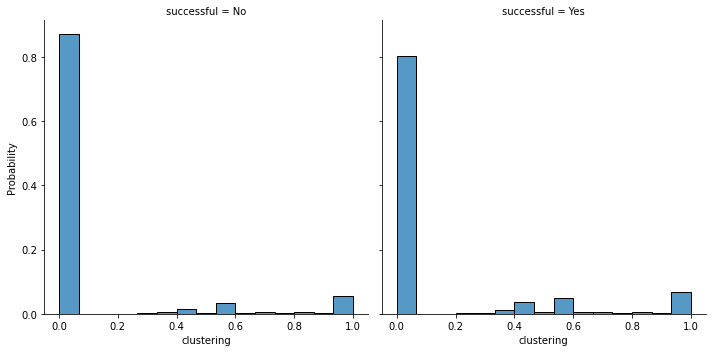

In [30]:
sns.displot(df_comp, x="clustering", col="successful", stat="probability", common_norm=False)

(0.0, 20.0)

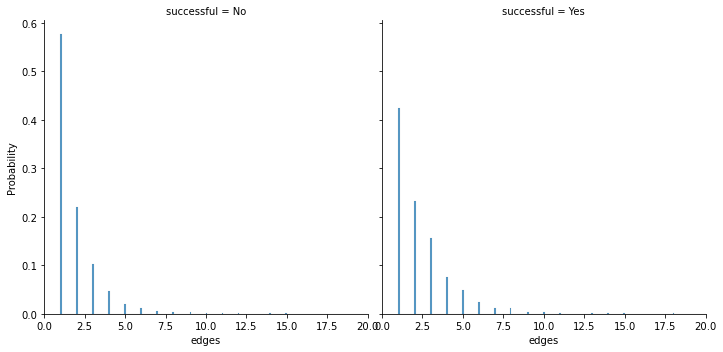

In [31]:
sns.displot(df_comp, x="edges", col="successful", stat="probability", common_norm=False)
plt.xlim([0, 20])

(0.0, 20.0)

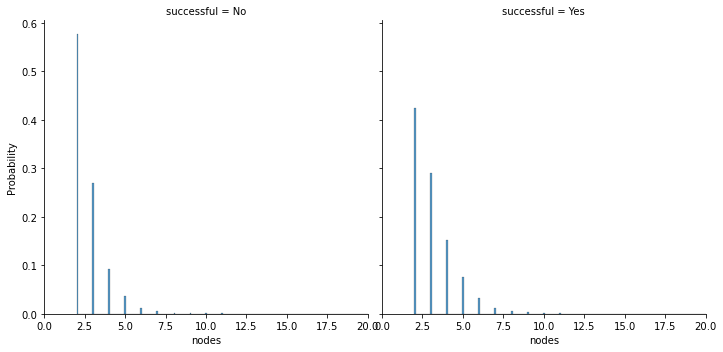

In [32]:
sns.displot(df_comp, x="nodes", col="successful", stat="probability", common_norm=False)
plt.xlim([0, 20])

In [33]:
df_comp.groupby('successful').mean()

,clustering,nodes,edges,weight,diameter
successful,,,,,
No,0.098490,2.693385,1.936486,3.872972,1.368338
Yes,0.136375,3.106865,2.467617,4.935233,1.507772


# What about women

In [34]:
data = []
columns = ['clustering', 'nodes', 'edges', 'weight', 'diameter', 'successful']
for i, graph in enumerate(graphs):
    for node in women_neighbors[i]:
        if node in women_succ_neighbors[i]:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            G = graph.subgraph([node] + first)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'Yes'])
        else:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            G = graph.subgraph([node] + first)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'No'])

In [35]:
df_comp_w = pd.DataFrame(data, columns=columns)

In [36]:
df_comp_w.groupby('successful').mean()

,clustering,nodes,edges,weight,diameter
successful,,,,,
No,0.097857,2.593796,1.812900,3.625800,1.340719
Yes,0.169249,3.028169,2.492958,4.985915,1.469484


## Men

In [37]:
data = []
columns = ['clustering', 'nodes', 'edges', 'weight', 'diameter', 'successful']
for i, graph in enumerate(graphs):
    for node in neighbors[i] - women_neighbors[i]:
        if node in succ_neighbors[i]:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            G = graph.subgraph([node] + first)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'Yes'])
        else:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            G = graph.subgraph([node] + first)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'No'])            

In [38]:
df_comp_m = pd.DataFrame(data, columns=columns)

In [39]:
df_comp_m.groupby('successful').mean()

,clustering,nodes,edges,weight,diameter
successful,,,,,
No,0.098662,2.720488,1.970119,3.940239,1.375854
Yes,0.131114,3.119459,2.463561,4.927122,1.513899


## First neighbors

In [40]:
data = []
columns = ['clustering', 'nodes', 'edges', 'weight', 'diameter', 'successful']
for i, graph in enumerate(graphs):
    for node in neighbors[i]:
        if node in succ_neighbors[i]:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            first_neighbors = []
            for f in first:
                first_neighbors.extend(list(nx.neighbors(graph, f)) + [f])
            first_neighbors = set(first_neighbors)
            first_neighbors = list(first_neighbors - neighbors[i])
            G = graph.subgraph([node] + first_neighbors)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'Yes'])
        else:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            first_neighbors = []
            for f in first:
                first_neighbors.extend(list(nx.neighbors(graph, f)) + [f])
            first_neighbors = set(first_neighbors)
            first_neighbors = list(first_neighbors - neighbors[i])
            G = graph.subgraph([node] + first_neighbors)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'No'])            

In [41]:
df_comp_fn = pd.DataFrame(data, columns=columns)

In [42]:
df_comp_fn.groupby('successful').mean()

,clustering,nodes,edges,weight,diameter
successful,,,,,
No,0.111863,3.887192,3.530335,7.060670,1.933537
Yes,0.144007,4.932642,4.760363,9.520725,2.289508


## Women

In [43]:
data = []
columns = ['clustering', 'nodes', 'edges', 'weight', 'diameter', 'successful']
for i, graph in enumerate(graphs):
    for node in women_neighbors[i]:
        if node in women_succ_neighbors[i]:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            first_neighbors = []
            for f in first:
                first_neighbors.extend(list(nx.neighbors(graph, f)) + [f])
            first_neighbors = set(first_neighbors)
            first_neighbors = list(first_neighbors - neighbors[i])
            G = graph.subgraph([node] + first_neighbors)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'Yes'])
        else:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            first_neighbors = []
            for f in first:
                first_neighbors.extend(list(nx.neighbors(graph, f)) + [f])
            first_neighbors = set(first_neighbors)
            first_neighbors = list(first_neighbors - neighbors[i])
            G = graph.subgraph([node] + first_neighbors)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'No'])            

In [44]:
df_comp_fn_w = pd.DataFrame(data, columns=columns)

In [45]:
df_comp_fn_w.groupby('successful').mean()

,clustering,nodes,edges,weight,diameter
successful,,,,,
No,0.112222,3.619399,3.220089,6.440177,1.850320
Yes,0.169881,4.643192,4.455399,8.910798,2.201878


## Men

In [46]:
data = []
columns = ['clustering', 'nodes', 'edges', 'weight', 'diameter', 'successful']
for i, graph in enumerate(graphs):
    for node in neighbors[i] - women_neighbors[i]:
        if node in succ_neighbors[i]:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            first_neighbors = []
            for f in first:
                first_neighbors.extend(list(nx.neighbors(graph, f)) + [f])
            first_neighbors = set(first_neighbors)
            first_neighbors = list(first_neighbors - neighbors[i])
            G = graph.subgraph([node] + first_neighbors)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'Yes'])
        else:
            first = set(nx.neighbors(graph, node))
            first = list(first - neighbors[i])
            first_neighbors = []
            for f in first:
                first_neighbors.extend(list(nx.neighbors(graph, f)) + [f])
            first_neighbors = set(first_neighbors)
            first_neighbors = list(first_neighbors - neighbors[i])
            G = graph.subgraph([node] + first_neighbors)
            c = nx.average_clustering(G)
            order = len(G)
            edges = len(G.edges)
            weight = sum(dict(G.degree(weight='weight')).values())
            diameter = nx.diameter(G)
            data.append([c, order, edges, weight, diameter, 'No'])            

In [47]:
df_comp_fn_m = pd.DataFrame(data, columns=columns)

In [48]:
df_comp_fn_m.groupby('successful').mean()

,clustering,nodes,edges,weight,diameter
successful,,,,,
No,0.111765,3.960070,3.614766,7.229532,1.956184
Yes,0.139866,4.978963,4.809166,9.618332,2.303531


# All together now

In [49]:
df_comp_fn_m['network'] = 'FN_male'
df_comp_fn_w['network'] = 'FN_female'
df_comp_fn['network'] = 'FN_all'
df_comp_m['network'] = 'Local_male'
df_comp_w['network'] = 'Local_female'
df_comp['network'] = 'Local_all'

In [50]:
df = pd.concat([df_comp, df_comp_w, df_comp_m, df_comp_fn,
                df_comp_fn_w, df_comp_fn_m])

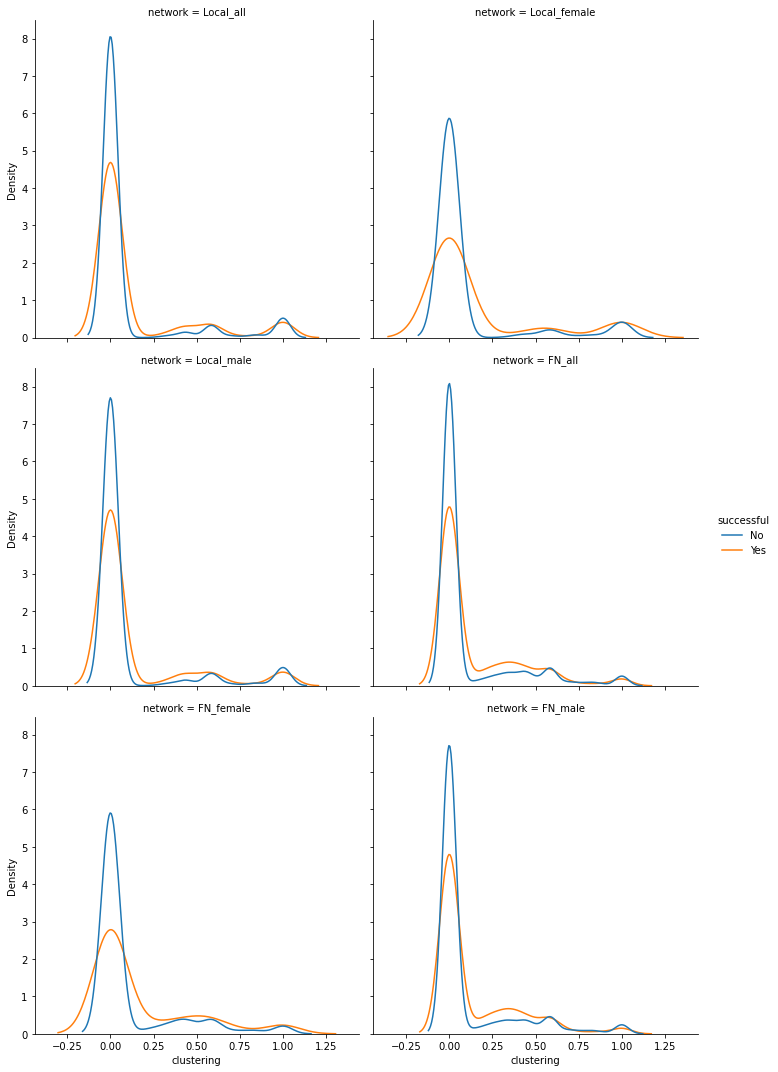

In [51]:
sns.displot(df, x="clustering", col='network', col_wrap=2, common_norm=False,
           col_order=['Local_all', 'FN_all', 'Local_female', 'Local_male',
                      'FN_female', 'FN_male'], hue='successful', kind='kde')

In [52]:
df_gb = df.groupby(['network', 'successful']).mean().reset_index()

In [53]:
df_gb_melt = df_gb.melt(id_vars=['network', 'successful'])

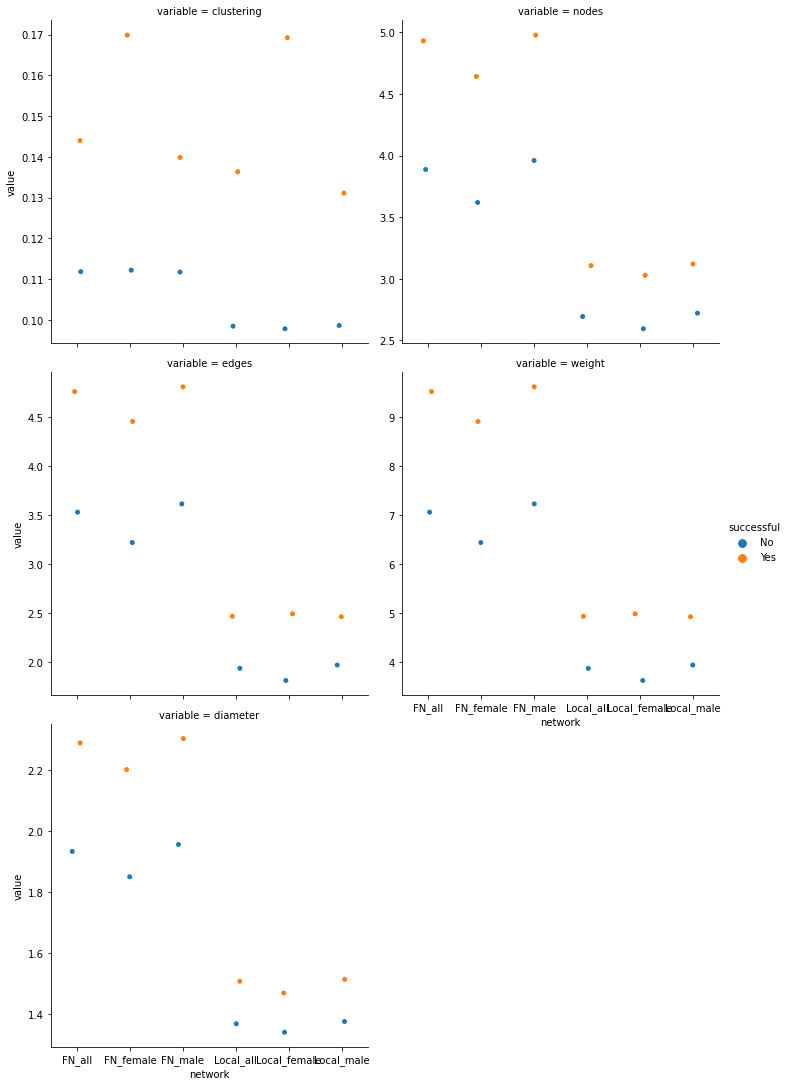

In [54]:
sns.catplot(data=df_gb_melt, x="network", y="value", col="variable", hue="successful", col_wrap=2, sharey=False)

# Hipótesis 2

Las carreras de las mujeres terminan antes.

Calculemos la proporción de mujeres que se encuentran en la red 5 años después.

In [55]:
article = pd.read_csv('../data/econometry/base_1_todos.csv')

article = article.dropna(subset=['year', 'gender'])

In [56]:
graphs = []
for i, year in enumerate(years):
    if year == 2000:
        chunk = article[article.year <= year]
    elif year == 2003:
        chunk = article[(article.year > 2000) & (article.year <= 2003)]
    elif year == 2005:
        chunk = article[(article.year > 2003) & (article.year <= 2005)]
    else:
        chunk = article[article.year == year]
    graphs.append(chunk['Short-Id'].unique())

In [57]:
data = []
columns = ['Kept', 'Female', 'Successful']
for i, neighbor in enumerate(neighbors):
    for node in neighbor:
        kept = 0
        women = False
        success = 0
        if node in graphs[i+5]:
            kept = 1
        if node in women_neighbors[i]:
            women = True
        if node in succ_neighbors[i]:
            success = 1
        data.append([kept, women, success])

In [58]:
df_2 = pd.DataFrame(data, columns=columns)

In [59]:
df_2_melt = df_2.melt(id_vars='Female')

In [60]:
df_2_gb = df_2_melt.groupby(['Female', 'variable']).mean().reset_index()

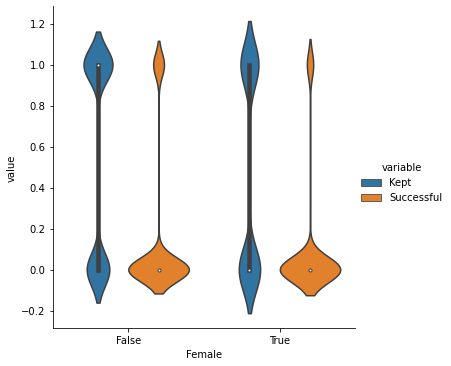

In [61]:
sns.catplot(x='Female', y='value', kind='violin', hue='variable', data=df_2_melt, sharey=False)

# Ages

## Super cited

In [62]:
article = article.sort_values(by='year')

In [63]:
age = article.groupby('Short-Id').year.first().rename('age').reset_index()

In [92]:
all_people = pd.merge(all_people, age, how='left')

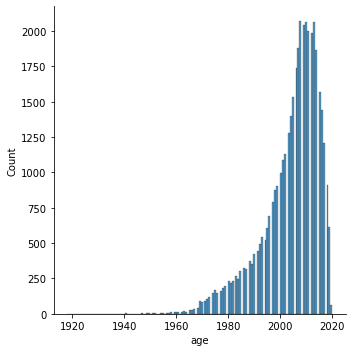

In [93]:
sns.displot(all_people, x='age')

In [102]:
age = []
gender = []
year = []
for i, sc in enumerate(super_cited):
    chunk = all_people[all_people['Short-Id'].isin(sc)]
    chunk['age'] = years[i] - chunk['age']
    year.extend([years[i]] * chunk.shape[0])
    gender.extend(list(chunk.gender.values))
    age.extend(list(chunk.age.values))

<ipython-input-102-ba26ebb16315>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['age'] = years[i] - chunk['age']


In [103]:
df_age = pd.DataFrame({'age': age, 'gender': gender, 'year': year})

In [104]:
df_age['year'] = df_age['year'].astype(str)

In [107]:
df_age_gb = df_age.groupby(['year', 'gender']).mean().reset_index()

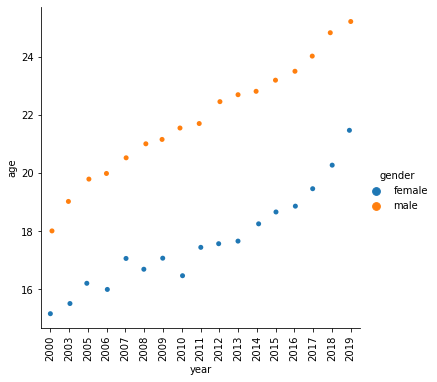

In [111]:
sns.catplot(data=df_age_gb, x='year', y='age', hue='gender')
plt.xticks(rotation=90);

## Neighbors

In [114]:
data = []
columns = ['Kept', 'Female', 'Successful', 'Age', 'Year']
for i, neighbor in enumerate(neighbors):
    for node in neighbor:
        age = all_people.loc[all_people['Short-Id']==node, 'age'].item()
        kept = 0
        women = False
        success = 0
        if node in graphs[i+5]:
            kept = 1
        if node in women_neighbors[i]:
            women = True
        if node in succ_neighbors[i]:
            success = 1
        data.append([kept, women, success, age, years[i]])

In [116]:
df_age_2 = pd.DataFrame(data, columns=['Kept', 'Female', 'Successful', 'Age', 'Year'])

In [118]:
df_age_2['Age'] = df_age_2['Year'] - df_age_2['Age']

In [147]:
df_age_2_gb = df_age_2.groupby(['Year', 'Successful', 'Female']).median().reset_index()

In [148]:
df_age_2_gb['Year'] = df_age_2_gb.Year.astype(str)

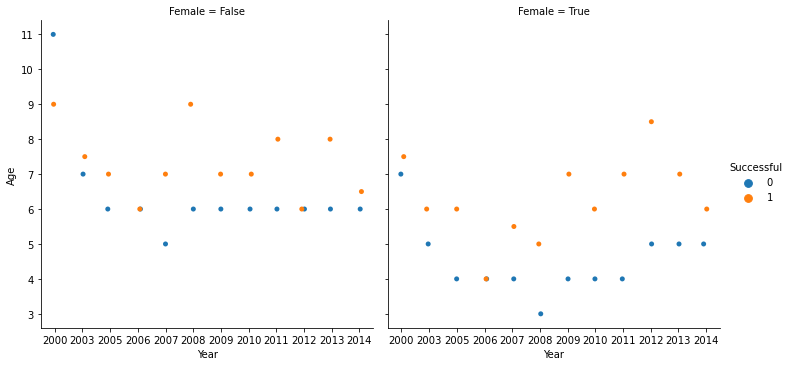

In [149]:
sns.catplot(x='Year', y='Age', col='Female', hue="Successful", data=df_age_2_gb, sharey=True)

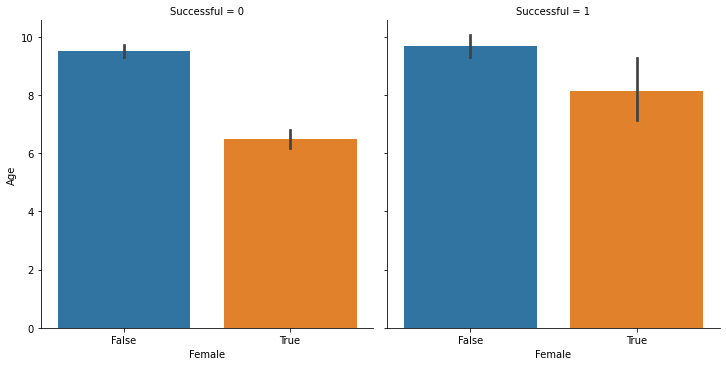

In [140]:
sns.catplot(x='Female', y='Age', kind='bar', col='Successful', data=df_age_2, sharey=True)

## Not neighbors

In [152]:
data = []
columns = ['Kept', 'Female', 'Successful', 'Age', 'Year']
for i, neighbor in enumerate(not_neighbors):
    for node in neighbor:
        age = all_people.loc[all_people['Short-Id']==node, 'age'].item()
        kept = 0
        women = False
        success = 0
        if node in graphs[i+5]:
            kept = 1
        if node in women_not_neighbors[i]:
            women = True
        if node in succ_not_neighbors[i]:
            success = 1
        data.append([kept, women, success, age, years[i]])

In [153]:
df_age_3 = pd.DataFrame(data, columns=['Kept', 'Female', 'Successful', 'Age', 'Year'])

In [154]:
df_age_3['Age'] = df_age_3['Year'] - df_age_3['Age']

In [158]:
df_age_3_gb = df_age_3.groupby(['Year', 'Successful', 'Female']).mean().reset_index()

In [159]:
df_age_3_gb['Year'] = df_age_3_gb.Year.astype(str)

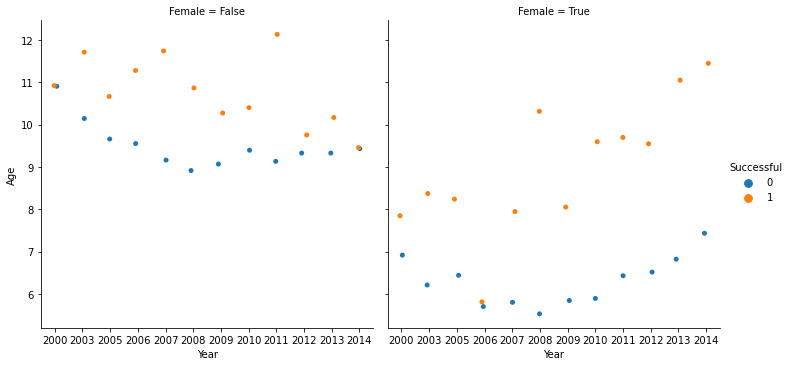

In [160]:
sns.catplot(x='Year', y='Age', col='Female', hue="Successful", data=df_age_3_gb, sharey=True)